# Includes

In [181]:
from commonfunctions import *
import cv2
import os
import sys
import tkinter as tk


## Face Detection

In [182]:
def detectFace(frame):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    # face = face_classifier.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    face = face_classifier.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)
    
    # Draw a rectangle around the faces (Used for testing purposes)
    # for (x, y, w, h) in face:
    #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)
    return face

## Left Pipeline
- Gray Conversion
- Noise Removal
- Edge Detection
- Dilation

### Gray Conversion

In [183]:
def grayConversion(frame):
    # conversion of BGR to grayscale is necessary to apply this operation
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

### Sharpening

In [184]:
def sharpen(frame):
    # sharpening the image
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(frame, -1, kernel)
    return sharpened

    # # gaussian filter
    # blur = cv2.GaussianBlur(frame, (5,5), 0)
    # # unsharp masking
    # sharpened = cv2.addWeighted(frame, 1.5, blur, -0.5, 0)
    # return sharpened


### Noise Removal

In [185]:
def noiseRemoval(frame):
    # noise removal using median filter
    median = cv2.medianBlur(frame, 11)
    # gaussian
    blur = cv2.GaussianBlur(median, (3,3), 0)
    return blur

### Edge Detection

In [186]:
# canny edge detector
def cannyDetector(frame):
    # canny = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    # canny edge detector
    canny = cv2.Canny(frame, 150, 190)
    return canny 


### Dilation

In [187]:
# dilation
def dilation(frame):
    # dilation
    kernel = np.ones((2, 2), np.uint8)
    dilation = cv2.dilate(frame, kernel, iterations=1)
    
    return dilation

### Color Conversion

In [188]:
def colorConversion(frame):
    # conversion of GRAY to BGR
    BGR = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    return BGR

In [189]:
def leftPipeline(frame):
    gray        = grayConversion(frame)
    denoised    = noiseRemoval(gray)
    sharpened   = sharpen(denoised)
    canny       = cannyDetector(sharpened)
    dilated     = dilation(canny)
    # BGR         = colorConversion(dilated)
    dilated = 255 - dilated
    return dilated

## Right Pipeline
- Separating RGB Channels
- Average Filtering
- Color Quantization
- Combining RGB Channels

### Separating RGB channels

In [190]:
def separateRGB(frame):
    # separate the RGB channels
    b, g, r = cv2.split(frame)
    return b, g, r

### Average Filtering

In [191]:
def averageFilter(b, g, r):
    # average filter
    b = cv2.blur(b, (5,5))
    g = cv2.blur(g, (5,5))
    r = cv2.blur(r, (5,5))
    return b, g, r

### Color Quantization
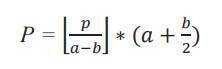

In [192]:
def quantize(b, g, r):
    x = 200
    y = 180
    
    # quantize the image
    b = np.uint8(b/(x - y))*(x + (y // 2))
    g = np.uint8(g/(x - y))*(x + (y // 2))
    r = np.uint8(r/(x - y))*(x + (y // 2))

    # normalize
    b = np.uint8(b/np.max(b)*255)
    g = np.uint8(g/np.max(g)*255)
    r = np.uint8(r/np.max(r)*255)

    return b, g, r

In [193]:
def KmeansQuantize(frame):
    # convert to RGB
    frame_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Reshape image to an Mx3 array
    img = frame_RGB.reshape(-1,3)

    print(len(np.unique(img, axis=0)), 'unique RGB values out of', img.shape[0], 'pixels')

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    compactness, labels, centers = cv2.kmeans(data = img.astype(np.float32), K = 100, bestLabels = None, criteria = criteria, attempts = 10, flags = cv2.KMEANS_RANDOM_CENTERS)

    colours = centers[labels].reshape(-1,3)

    print(len(np.unique(colours, axis=0)), 'unique RGB values out of', colours.shape[0], 'pixels')

    img_colours = colours.reshape(frame_RGB.shape)
    
    return img_colours

### Combining RGB Channels

In [194]:
def combine(b, g, r):
    # combine the channels
    combined = cv2.merge((b, g, r))
    return combined

In [195]:
def rightPipeline(frame):
    b, g, r = separateRGB(frame)
    b, g, r = averageFilter(b, g, r)
    b, g, r = quantize(b, g, r)
    combined = combine(b, g, r)
    # combined = KmeansQuantize(combined)
    
    return combined

In [196]:
def rightPipelineFace(frame):
    b, g, r = separateRGB(frame)
    b, g, r = averageFilter(b, g, r)
    # b, g, r = quantize(b, g, r)
    combined = combine(b, g, r)
    combined = KmeansQuantize(combined)
    
    return combined

### Reading the video frame by frame

In [197]:
# Creating a VideoCapture object to read the video

# cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')

# detectFaceMode = True           # Flag for face detection mode



def VideoCartoonizer(detectFaceMode = False):
    frameCounter = 0                # Counter for face detection mode
    skipFrames = 10                 # number of frames to skip before detecting faces again
    faces = []                      # List of faces detected in the frame
    videos = os.listdir("data/Videos/")
    cap = cv2.VideoCapture("data/Videos/" + videos[1])
    try:
        # Loop until the end of the video
        while (cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:     # If there is no frame to read, i.e. end of video
                break

            # resize the frame
            frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
                                interpolation = cv2.INTER_CUBIC)

            leftPipe = leftPipeline(frame)          # The left pipeline is applied regardless of the face detection mode

            # Check for face detection mode
            if detectFaceMode:      # Face detection mode - Cartoonize only the face
                # This ensures that regions outside ROI remain unchanged
                rightPipe = frame.copy()            
                combined = frame.copy()
                
                if frameCounter % skipFrames == 0:     # Reset the counter
                    faces = detectFace(frame)
                    frameCounter = 0    

                # Loop over the ROI and apply the right pipeline
                for face in faces:
                    x, y, w, h = face

                    # leftPipe[y : y+h, x : x+w] = leftPipeline(frame[y : y+h, x : x+w])
                    rightPipe[y : y+h, x : x+w] = rightPipelineFace(frame[y : y+h, x : x+w])
                    # Now, we combine only the ROI of the frame
                    combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])
                
                
                frameCounter += 1

            else:       # Normal mode - Cartoonize the whole frame
                leftPipe = leftPipeline(frame)
                rightPipe = rightPipeline(frame)
                combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)

            
            cv2.imshow('Frame', frame)                  # Display the original frame
            cv2.imshow('left', leftPipe)                # Display the left pipeline result
            cv2.imshow('right', rightPipe)              # Display the right pipeline result
            cv2.imshow('da5alo f ba3d', combined)       # Display the combined image

            
            # define q as the exit button
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            
    except Exception as e:
        # Throw the exception after releasing the video capture object
        cap.release()
        cv2.destroyAllWindows()
        raise e
        # kda msh bn7tag n3ml restart lel kernel m3 kol error
    
    # release the video capture object
    cap.release()
    # Closes all the windows currently opened.
    cv2.destroyAllWindows()

### Photo Testing

In [198]:
# os.listdir("data/Photos/")
def TestPhotos(detectFaceMode = False):
    cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')
    for photo in os.listdir("data/Photos/"):
        frame = cv2.imread("data/Photos/"+photo, cv2.IMREAD_COLOR)

        frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
                            interpolation = cv2.INTER_CUBIC)
        

        
        leftPipe = leftPipeline(frame)          # The left pipeline is applied regardless of the face detection mode

        # Check for face detection mode
        if detectFaceMode:      # Face detection mode - Cartoonize only the face
            # This ensures that regions outside ROI remain unchanged
            rightPipe = frame.copy()            
            combined = frame.copy()
            
            faces = detectFace(frame)
            
            # Loop over the ROI and apply the right pipeline
            for face in faces:
                x, y, w, h = face
                rightPipe[y : y+h, x : x+w] = rightPipelineFace(frame[y : y+h, x : x+w])
                # Now, we combine only the ROI of the frame
                combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])

        else:
            leftPipe = leftPipeline(frame)
            rightPipe = rightPipeline(frame)
            combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)
        
        
        cv2.imshow('Frame', frame)                  # Display the original frame
        cv2.imshow('left', leftPipe)                # Display the left pipeline result
        cv2.imshow('right', rightPipe)              # Display the right pipeline result
        cv2.imshow('da5alo f ba3d', combined)       # Display the combined image
        
        # define q as the exit button
        while True:
            key = cv2.waitKey(25)
            if key & 0xFF == ord('q'):
                break
            elif key & 0xFF == ord('e'):
                # release the video capture object
                cap.release()
                # Closes all the windows currently opened.
                cv2.destroyAllWindows()
                # sys.exit()
                return
    
    # release the video capture object
    cap.release()
    # Closes all the windows currently opened.
    cv2.destroyAllWindows()

In [199]:
detectFaceMode = True
TestPhotos(detectFaceMode)

In [200]:
# cap = cv2.VideoCapture('data/Succession-Season-1-1080.mp4')
# frame = cv2.imread("test1.jpg", cv2.IMREAD_COLOR)

# frame = cv2.resize(frame, (540, 380), fx = 0, fy = 0,
#                     interpolation = cv2.INTER_CUBIC)

# # Display the resulting frame
# cv2.imshow('Frame', frame)

# # conversion of BGR to grayscale is necessary to apply this operation
# leftPipe = leftPipeline(frame)          # The left pipeline is applied regardless of the face detection mode

# # Check for face detection mode
# if detectFaceMode:      # Face detection mode - Cartoonize only the face
#     # This ensures that regions outside ROI remain unchanged
#     rightPipe = frame.copy()            
#     combined = frame.copy()
    
#     faces = detectFace(frame)
    
#     # Loop over the ROI and apply the right pipeline
#     for face in faces:
#         x, y, w, h = face
#         rightPipe[y : y+h, x : x+w] = rightPipeline(frame[y : y+h, x : x+w])
#         # Now, we combine only the ROI of the frame
#         combined[y : y+h, x : x+w] = cv2.bitwise_and(rightPipe[y : y+h, x : x+w], rightPipe[y : y+h, x : x+w], mask=leftPipe[y : y+h, x : x+w])

# else:
#     leftPipe = leftPipeline(frame)
#     rightPipe = rightPipeline(frame)
#     combined = cv2.bitwise_and(rightPipe, rightPipe, mask=leftPipe)


# cv2.imshow('Frame', frame)                  # Display the original frame
# cv2.imshow('left', leftPipe)                # Display the left pipeline result
# cv2.imshow('right', rightPipe)              # Display the right pipeline result
# cv2.imshow('da5alo f ba3d', combined)       # Display the combined image

# # define q as the exit button
# while True:
#     key = cv2.waitKey(25)
#     if key & 0xFF == ord('q'):
#         break
#     elif key & 0xFF == ord('e'):
#         # release the video capture object
#         cap.release()
#         # Closes all the windows currently opened.
#         cv2.destroyAllWindows()
#         sys.exit()
#         # return

# # release the video capture object
# cap.release()
# # Closes all the windows currently opened.
# cv2.destroyAllWindows()

# GUI

In [201]:
class MyGUI:

    def __init__(self):
        self.main_window = tk.Tk()
        self.main_window.geometry('400x250')
        # change color of the background to pink
        self.main_window.configure(bg='#ffcdd6')
        
        self.check_state = tk.IntVar()
        
        self.cartoonize_option = tk.Checkbutton(self.main_window, text='Cartoonize Face Only',font=('Callibri', 16 ), variable=self.check_state, onvalue=1, offvalue=0)    
        self.cartoonize_option.configure(bg='#cb3333')
        self.cartoonize_option.configure(fg='black')
        self.cartoonize_option.configure(activebackground='#ffcdd6')
        self.cartoonize_option.pack(side='top', pady=25)
        
        self.start_cartoonize_button = tk.Button(self.main_window, text='Start Photo Cartoonization', command=self.get_cartoonize_option)
        self.start_cartoonize_button.configure(bg='#cb3333')
        self.start_cartoonize_button.configure(fg='white')
        self.start_cartoonize_button.pack(pady=10)

        self.start_cartoonize_button_video = tk.Button(self.main_window, text='Start Video Cartoonization', command=self.get_cartoonize_option_video)
        self.start_cartoonize_button_video.configure(bg='#cb3333')
        self.start_cartoonize_button_video.configure(fg='white')
        self.start_cartoonize_button_video.pack(pady=10)
        
        self.quit_button = tk.Button(self.main_window, text='Quit', command=self.main_window.destroy)
        
        self.quit_button.configure(bg='#cb3333')
        self.quit_button.configure(fg='white')
        self.quit_button.pack(side='bottom', pady=10)

        
        self.main_window.mainloop()
        
    def get_cartoonize_option(self):
        
        TestPhotos(self.check_state.get())
    
    def get_cartoonize_option_video(self):
        
        VideoCartoonizer(self.check_state.get())
    
        
MyGUI()

2264 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
2232 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
3827 unique RGB values out of 4624 pixels
4 unique RGB values out of 4624 pixels
2271 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
2239 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
3806 unique RGB values out of 4624 pixels
4 unique RGB values out of 4624 pixels
2264 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
2246 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
3798 unique RGB values out of 4624 pixels
4 unique RGB values out of 4624 pixels
2271 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
2252 unique RGB values out of 2500 pixels
4 unique RGB values out of 2500 pixels
3841 unique RGB values out of 4624 pixels
4 unique RGB values out of 4624 pixels
2293 unique RGB values out o